This script fits the random forest model for the course BIO 101, using the full set of predictors.

In [26]:
import pickle
import pandas as pd
import numpy as np
from collections import Counter
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats.mstats import gmean
import seaborn as sns
import matplotlib.pyplot as plt

results_dir = "~\\Box Sync\\Clickstream\\evaluation_results\\full\\"

In [27]:
sn_dict = {"Blue Ridge": "BRCC",
           "Central Virginia": "CVCC",
           "Dabney S. Lancaster": "DSLCC",
           "Danville": "DCC",
           "Eastern Shore": "ESCC",
           "Germanna": "GCC",
           'J. Sargeant Reynolds': "JSRCC",
           'John Tyler': "JTCC",
           "Lord Fairfax": "LFCC",
           "Mountain Empire": "MECC",
           "New River": "NRCC",
           "Northern Virginia": "NVCC",
           "Patrick Henry": "PHCC",
           "Paul D. Camp": "PDCCC",
           "Piedmont Virginia": "PVCC",
           "Rappahannock": "RCC",
           "Southside Virginia": "SSVCC",
           "Southwest Virginia": "SWVCC",
           "Thomas Nelson": "TNCC",
           "Tidewater": "TCC",
           "Virginia Highlands": "VHCC",
           "Virginia Western": "VWCC",
           "Wytheville": "WCC"}

In [28]:
df0 = pd.read_csv("~\\Box Sync\\Clickstream\\data\\full\\LMS_data_final_full_new.csv")
df1 = pd.read_csv("~\\Box Sync\\Clickstream\\data\\full\\course_specific_predictors_new.csv")
df2 = pd.read_csv("~\\Box Sync\\Clickstream\\data\\full\\term_specific_predictors_new.csv")
df3 = pd.read_csv("~\\Box Sync\\Clickstream\\data\\full\\cluster_specific_predictors.csv")
df3 = df3.loc[:,['vccsid','strm','college','course','section'] + [e for e in df3.columns.values if e.endswith("SCI") or e.endswith("SCI_grade")]]
df4 = pd.read_stata("~\\Box Sync\\Clickstream\\data\\full\\instructor_related_predictors.dta")
df = df0.merge(df1, how='inner', on=['vccsid','strm','college','course','section'])\
.merge(df2, how='inner', on=['vccsid','strm'])\
.merge(df3, how='inner', on=['vccsid','strm','college','course','section'])\
.merge(df4, how='inner', on=['vccsid','strm','college','course','section'])
df = df[df.course == "BIO_101"]
df.loc[:,'first_ind'] = 0

In [29]:
df0 = pd.read_stata("~\\Box Sync\\Clickstream\\data\\first\\LMS_data_final.dta")
df1 = pd.read_csv("~\\Box Sync\\Clickstream\\data\\first\\course_specific_predictors_new.csv")
df2 = pd.read_csv("~\\Box Sync\\Clickstream\\data\\first\\term_specific_predictors_new.csv")
df4 = pd.read_stata("~\\Box Sync\\Clickstream\\data\\first\\instructor_related_predictors.dta")
df5 = df0.loc[:,['vccsid','strm','college','course','section']].copy()
df_first = df0.merge(df1, how='inner', on=['vccsid','strm','college','course','section'])\
.merge(df2, how='inner', on=['vccsid','strm'])\
.merge(df4, how='inner', on=['vccsid','strm','college','course','section'])\
.merge(df5, how='inner', on=['vccsid','strm','college','course','section'])
df_first = df_first[df_first.course == "BIO_101"]
df_first.loc[:,'first_ind'] = 1

In [30]:
df = pd.concat([df, df_first], axis=0, join='outer').fillna(0)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [31]:
Counter(df.first_ind)

Counter({0: 32208, 1: 6598})

In [32]:
for v in [int(e) for e in np.unique(df.cip) if e != 0]:
    df.loc[:,'cip_'+str(v)] = (df.cip == v).astype(int)
for v in [int(e) for e in np.unique(df.degree_level) if e != 4]:
    df.loc[:,'degree_level_'+str(v)] = (df.degree_level == v).astype(int)
df = df.drop(['cip', 'degree_level'], axis=1)
df.loc[:,'college_new'] = df.college.apply(lambda x: sn_dict[x])
for sn in [e for e in sn_dict.values() if e != "BRCC"]:
    df.loc[:,'college_'+sn] = (df.college_new == sn).astype(int)
df = df.drop(['college_new'], axis=1)

In [33]:
test = df.describe().T
test[test['mean'] == 0]

,count,mean,std,min,25%,50%,75%,max
has_prereq_grade,38806.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lvl2_ind,38806.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
prereq_grade,38806.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
df = df.drop(['lvl2_ind', 'has_prereq_grade', 'prereq_grade'], axis=1)
predictors = [e for e in list(df.columns) if e not in {"grade",'vccsid','strm','college','course','section'}]
len(predictors)

147

In [35]:
assert pd.isnull(df).any().any() == False

In [36]:
df.shape

(38806, 153)

In [37]:
train_df = df[df.strm != 2212]
test_df = df[df.strm == 2212]
original_test_grade = np.array(test_df.grade)
train_df.loc[:,'grade'] = train_df.apply(lambda x: 1 if x.loc['grade'] in {'A','B','C'} else 0, axis=1)
test_df.loc[:,'grade'] = test_df.apply(lambda x: 1 if x.loc['grade'] in {'A','B','C'} else 0, axis=1)
print(train_df.shape,test_df.shape)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(29925, 153) (8881, 153)


In [38]:
online_ind_df_1 = pd.read_stata("~\\Box Sync\\Clickstream\\data\\full\\updated_online_ind.dta")
online_ind_df_2 = pd.read_stata("~\\Box Sync\\Clickstream\\data\\first\\updated_online_ind.dta")
online_ind_df = pd.concat([online_ind_df_1, online_ind_df_2])
test_df = test_df.merge(online_ind_df, how='inner', on=['vccsid','strm','college','course','section'])

In [43]:
Counter(test_df.inperson_ind)

Counter({0.0: 8873, 1.0: 8})

In [44]:
test_df[np.array(test_df.inperson_ind == 1) & np.array(test_df.first_ind == 1)].shape[0]

1

In [15]:
online_ind = test_df.online_ind_y
inperson_ind = test_df.inperson_ind

,ART_SCI,ART_SCI_grade,BUS_SCI,BUS_SCI_grade,EGR_SCI,EGR_SCI_grade,FLA_SCI,FLA_SCI_grade,HUM_SCI,HUM_SCI_grade,...,college_DSLCC,college_PHCC,college_RCC,college_VWCC,college_WCC,college_NRCC,college_JSRCC,college_CVCC,online_ind_y,inperson_ind
0,1.0,3.0,1.0,4.0,1.0,1.500000,1.0,4.000000,1.0,3.500000,...,0,0,0,0,0,0,0,0,1.0,0.0
1,1.0,3.0,1.0,4.0,1.0,1.500000,1.0,4.000000,1.0,3.500000,...,0,0,0,0,0,0,0,0,1.0,0.0
2,1.0,3.0,1.0,4.0,1.0,3.000000,0.0,0.000000,1.0,3.700000,...,0,0,0,0,0,0,0,0,1.0,0.0
3,1.0,3.0,1.0,4.0,1.0,3.000000,0.0,0.000000,1.0,3.700000,...,0,0,0,0,0,0,0,0,1.0,0.0
4,0.0,0.0,1.0,2.0,1.0,3.000000,0.0,0.000000,1.0,3.000000,...,0,0,0,0,0,0,0,0,1.0,0.0
5,0.0,0.0,1.0,2.0,1.0,3.000000,0.0,0.000000,1.0,3.000000,...,0,0,0,0,0,0,0,0,1.0,0.0
6,0.0,0.0,1.0,4.0,1.0,4.000000,0.0,0.000000,1.0,2.538461,...,0,0,0,0,0,0,0,0,1.0,0.0
7,0.0,0.0,1.0,4.0,1.0,4.000000,0.0,0.000000,1.0,2.538461,...,0,0,0,0,0,0,0,0,1.0,0.0
8,1.0,3.0,1.0,3.0,1.0,3.571429,0.0,0.000000,1.0,3.437500,...,0,0,0,0,0,0,0,0,1.0,0.0
9,1.0,3.0,1.0,3.0,1.0,3.571429,0.0,0.000000,1.0,3.437500,...,0,0,0,0,0,0,0,0,1.0,0.0


In [13]:
Counter(test_df.first_ind)

Counter({0: 8277, 1: 604})

In [13]:
def create_cv_folds(train, n_fold = 5):
    folds = []
    k_fold = StratifiedKFold(n_splits = n_fold, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train, train.grade):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        X_1 = train_part.loc[:,predictors]
        y_1 = train_part.grade
        X_2 = test_part.loc[:,predictors]
        y_2 = test_part.grade
        folds.append([(X_1.copy(),y_1.copy()),(X_2.copy(),y_2.copy())])
    return folds

In [14]:
five_folds = create_cv_folds(train_df)

In [15]:
def cross_validation_RF(rf_model, folds):
    auc_by_fold = []
    for f in folds:
        X_1 = f[0][0]
        y_1 = f[0][1]
        X_2 = f[1][0]
        y_2 = f[1][1]
        rf_model.fit(X_1,y_1)
        y_2_pred = rf_model.predict_proba(X_2)[:,1]
        auc_by_fold.append(roc_auc_score(y_2,y_2_pred))
    return round(np.mean(auc_by_fold),4)  

In [16]:
def calc_cw(y):
    # Calculate the weight of each letter grade to be used in the modeling fitting procedure: the weight is inversely proportional to the square root of the frequency of the letter grade in the training sample
    cw = Counter(y)
    class_weight = {k:np.sqrt(cw.most_common()[0][-1]/v, dtype=np.float32) for k,v in cw.items()}
    return class_weight # The output is a dictionary mapping letter grade to the corresponding weight

Max_depth = 2
Mean CV AUC: 0.7802

Max_depth = 3
Mean CV AUC: 0.7935

Max_depth = 4
Mean CV AUC: 0.8033

Max_depth = 5
Mean CV AUC: 0.8132

Max_depth = 6
Mean CV AUC: 0.8213

Max_depth = 7
Mean CV AUC: 0.829

Max_depth = 8
Mean CV AUC: 0.8367

Max_depth = 9
Mean CV AUC: 0.8448

Max_depth = 10
Mean CV AUC: 0.8525

Max_depth = 11
Mean CV AUC: 0.86

Max_depth = 12
Mean CV AUC: 0.8672

Max_depth = 13
Mean CV AUC: 0.874

Max_depth = 14
Mean CV AUC: 0.8791

Max_depth = 15
Mean CV AUC: 0.8841

Max_depth = 16
Mean CV AUC: 0.8877

Max_depth = 17
Mean CV AUC: 0.8913

Max_depth = 18
Mean CV AUC: 0.8944

Max_depth = 19
Mean CV AUC: 0.8963

Max_depth = 20
Mean CV AUC: 0.8984

Max_depth = 21
Mean CV AUC: 0.8993

Max_depth = 22
Mean CV AUC: 0.9012

Max_depth = 23
Mean CV AUC: 0.9018

Max_depth = 24
Mean CV AUC: 0.9032

Max_depth = 25
Mean CV AUC: 0.9028



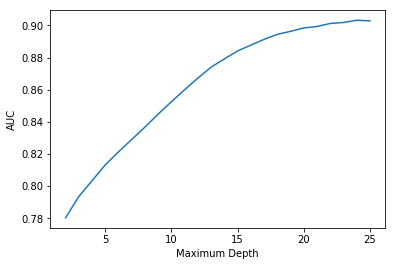

In [18]:
### Using grid search to find the optimal maximum tree depth
auc_by_d=[]
for d in range(2,26):
    rf = RandomForestClassifier(n_estimators=200, criterion="entropy", 
                                max_depth=d,
                                random_state=0, n_jobs=20, max_features="auto",
                                class_weight = calc_cw(train_df.grade))
    auc = cross_validation_RF(rf, five_folds)
    auc_by_d.append(auc)
    print("Max_depth =", d)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(2,26),auc_by_d)
plt.xlabel("Maximum Depth")
plt.ylabel("AUC")
plt.show()

Number of Trees = 100
Mean CV AUC: 0.9014

Number of Trees = 120
Mean CV AUC: 0.9019

Number of Trees = 140
Mean CV AUC: 0.9025

Number of Trees = 160
Mean CV AUC: 0.9028

Number of Trees = 180
Mean CV AUC: 0.9032

Number of Trees = 200
Mean CV AUC: 0.9032

Number of Trees = 220
Mean CV AUC: 0.9034

Number of Trees = 240
Mean CV AUC: 0.9035

Number of Trees = 260
Mean CV AUC: 0.9036

Number of Trees = 280
Mean CV AUC: 0.9036

Number of Trees = 300
Mean CV AUC: 0.9037



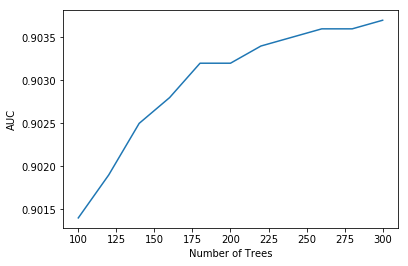

In [19]:
### Using grid search to find the optimal number of estimators (trees)
auc_by_n = []
for n in range(100,320,20):
    rf = RandomForestClassifier(n_estimators=n, criterion="entropy", 
                                max_depth=24,
                                random_state=0, n_jobs=-1, max_features="auto",
                                class_weight = calc_cw(train_df.grade))
    auc = cross_validation_RF(rf, five_folds)
    auc_by_n.append(auc)
    print("Number of Trees =", n)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(100,320,20), auc_by_n)
plt.xlabel("Number of Trees")
plt.ylabel("AUC")
plt.show()

In [20]:
### Using grid search to find the optimal maximum number of features (trees)
auc_by_nf = []
max_nf = int(np.floor(2*np.sqrt(len(predictors))))
for nf in range(2,max_nf+1):
    rf = RandomForestClassifier(n_estimators=180, criterion="entropy", 
                                max_depth=24,
                                random_state=0, n_jobs=-1, max_features=nf,
                                class_weight = calc_cw(train_df.grade))
    auc = cross_validation_RF(rf, five_folds)
    auc_by_nf.append(auc)
    print("Max_features =", nf)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(2,max_nf+1), auc_by_nf)
plt.xlabel("Maximum Number of Features")
plt.ylabel("AUC")
plt.show()

Max_features = 2
Mean CV AUC: 0.8942

Max_features = 3
Mean CV AUC: 0.8969

Max_features = 4
Mean CV AUC: 0.9006

Max_features = 5
Mean CV AUC: 0.9007

Max_features = 6
Mean CV AUC: 0.9011

Max_features = 7
Mean CV AUC: 0.9015



KeyboardInterrupt: 

In [17]:
rf = RandomForestClassifier(n_estimators=180, criterion="entropy",
                            max_depth=24,
                            random_state=0, n_jobs=-1, max_features=4,
                            class_weight = calc_cw(train_df.grade))
rf.fit(train_df.loc[:,predictors], train_df.grade)

RandomForestClassifier(bootstrap=True, class_weight={0: 1.6805598, 1: 1.0},
            criterion='entropy', max_depth=24, max_features=4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=180, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [15]:
print("Random Forest:")
print("Overall AUC = {}".format(round(roc_auc_score(test_df.grade, rf.predict_proba(test_df.loc[:,predictors])[:,1]),4)))
y_test_pred_rf = rf.predict_proba(test_df.loc[:,predictors])[:,1]

Random Forest:
Overall AUC = 0.8426


In [16]:
print("Random Forest:")
print("Non-first AUC = {}".format(round(roc_auc_score(test_df[test_df.first_ind == 0].grade, rf.predict_proba(test_df[test_df.first_ind == 0].loc[:,predictors])[:,1]),4)))
y_test_pred_rf_nonfirst = rf.predict_proba(test_df[test_df.first_ind == 0].loc[:,predictors])[:,1]

Random Forest:
Non-first AUC = 0.8461


In [17]:
print("Random Forest:")
print("First AUC = {}".format(round(roc_auc_score(test_df[test_df.first_ind == 1].grade, rf.predict_proba(test_df[test_df.first_ind == 1].loc[:,predictors])[:,1]),4)))
y_test_pred_rf_first = rf.predict_proba(test_df[test_df.first_ind == 1].loc[:,predictors])[:,1]

Random Forest:
First AUC = 0.8123


In [18]:
print("Random Forest:")
print("Online AUC = {}".format(round(roc_auc_score(test_df[test_df.online_ind == 1].grade, rf.predict_proba(test_df[test_df.online_ind == 1].loc[:,predictors])[:,1]),4)))
y_test_pred_rf_first = rf.predict_proba(test_df[test_df.online_ind == 1].loc[:,predictors])[:,1]

Random Forest:
Online AUC = 0.8504


In [19]:
print("Random Forest:")
print("In-person AUC = {}".format(round(roc_auc_score(test_df[test_df.online_ind == 0].grade, rf.predict_proba(test_df[test_df.online_ind == 0].loc[:,predictors])[:,1]),4)))
y_test_pred_rf_first = rf.predict_proba(test_df[test_df.online_ind == 0].loc[:,predictors])[:,1]

Random Forest:
In-person AUC = 0.8384


In [18]:
# print("ABC vs. DF")
# print("AUC = {}".format(round(roc_auc_score(np.array(test_df.grade)[np.where(np.array(original_test_grade) != "W")[0]], 
#                                             rf.predict_proba(test_df.loc[:,predictors])[np.where(np.array(original_test_grade) != "W")[0],1]),4)))

In [19]:
# def find_optimal_threshold(p,r,t):
#     to_drop = np.union1d(np.where(pd.isnull(p[:-1]) == True)[0], np.where(pd.isnull(r[:-1]) == True)[0])
#     to_drop = np.union1d(to_drop, np.where(pd.isnull(t) == True)[0])
#     to_keep = np.setdiff1d(np.array(list(range(len(p)-1))), to_drop)
#     p,r,t = p[to_keep],r[to_keep],t[to_keep]
#     to_keep_2 = np.where(t < 0.8)[0]
#     p,r,t = p[to_keep_2],r[to_keep_2],t[to_keep_2]
#     f1 = 2*p*r/(p+r)
#     best_t = t[np.argmax(f1)]
#     best_t
#     return best_t

# def cross_validation(train, model):
#     threshold_list = []
#     auc_list = []
#     k_fold =  StratifiedKFold(n_splits = 10, random_state = 54321, shuffle=True)
#     for train_indices, test_indices in k_fold.split(train, train.grade):
#         train_part = train.iloc[train_indices,:]
#         test_part = train.iloc[test_indices,:]
#         X_1 = train_part.loc[:,predictors]
#         y_1 = train_part.grade
#         X_2 = test_part.loc[:,predictors]
#         y_2 = test_part.grade
#         model.fit(X_1,y_1)
#         p,r,t = precision_recall_curve(1-np.array(y_2), model.predict_proba(X_2)[:,0])
#         threshold_list.append(1-find_optimal_threshold(p,r,t))
#         auc = roc_auc_score(y_2, model.predict_proba(X_2)[:,1])
#         auc_list.append(auc)
#     print(threshold_list)
#     print(np.mean(auc_list), np.std(auc_list, ddof=1))
#     return gmean(threshold_list)

In [20]:
# best_threshold = cross_validation(train_df,rf)

In [21]:
# best_threshold

In [22]:
best_threshold = np.sort(y_test_pred_rf)[int(len(y_test_pred_rf) * (1-np.mean(train_df.grade)))-1]

In [23]:
def create_confusion_matrix_old(y_test_pred, threshold, fname):
    cm_arr = confusion_matrix(y_test, np.where(y_test_pred > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_DFW','Pred_ABC'], index=['Actual_DFW', 'Actual_ABC'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score for A/B/C = {}".format(round(2*p1*r1/(p1+r1),4)))
    print("F1 score for D/F/W = {}".format(round(2*p0*r0/(p0+r0),4))) 
    cm_df.to_csv(results_dir + fname + ".csv")
    y_test_pred_bin = np.where(y_test_pred > best_threshold, 1, 0)
    cm_dict = {}
    cm_dict['Pred_DFW'] = Counter(original_test_grade[np.where(y_test_pred_bin==0)[0]])
    cm_dict['Pred_ABC'] = Counter(original_test_grade[np.where(y_test_pred_bin==1)[0]])
    new_cm = pd.DataFrame.from_dict(cm_dict, orient='index').T.loc[['W','F','D','C','B','A'],['Pred_DFW','Pred_ABC']]
    new_cm.index = ["Actual_"+e for e in new_cm.index]
    new_cm.loc[:,''] = new_cm.sum(axis=1)
    new_cm.loc['',:] = new_cm.sum(axis=0)
    new_cm.to_csv(results_dir + fname + "_6x2.csv")
    return round(p1,4),round(r1,4),round(p0,4),round(r0,4),round(2*p1*r1/(p1+r1),4),round(2*p0*r0/(p0+r0),4)

In [24]:
y_test = np.array(test_df.grade)
print("F1 threshold = {}:\n".format(str(round(best_threshold,4))))
pr_rf = create_confusion_matrix_old(y_test_pred_rf, best_threshold, "RF_BIO101_all_cm")

F1 threshold = 0.6188:

            Pred_DFW  Pred_ABC        
Actual_DFW    1548.0     996.0  2544.0
Actual_ABC     774.0    5563.0  6337.0
              2322.0    6559.0  8881.0

F1 score for A/B/C = 0.8627
F1 score for D/F/W = 0.6363


In [25]:
pr_rf

(0.8481, 0.8779, 0.6667, 0.6085, 0.8627, 0.6363)

In [26]:
def create_confusion_matrix(y_test_pred, threshold, fname, ind = 0):
    cm_arr = confusion_matrix(y_test[np.array(test_df.first_ind == ind)], np.where(y_test_pred > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_DFW','Pred_ABC'], index=['Actual_DFW', 'Actual_ABC'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score for A/B/C = {}".format(round(2*p1*r1/(p1+r1),4)))
    print("F1 score for D/F/W = {}".format(round(2*p0*r0/(p0+r0),4))) 
    cm_df.to_csv(results_dir + fname + ".csv")
    y_test_pred_bin = np.where(y_test_pred > best_threshold, 1, 0)
    cm_dict = {}
    cm_dict['Pred_DFW'] = Counter(original_test_grade[np.array(test_df.first_ind == ind)][np.where(y_test_pred_bin==0)[0]])
    cm_dict['Pred_ABC'] = Counter(original_test_grade[np.array(test_df.first_ind == ind)][np.where(y_test_pred_bin==1)[0]])
    new_cm = pd.DataFrame.from_dict(cm_dict, orient='index').T.loc[['W','F','D','C','B','A'],['Pred_DFW','Pred_ABC']]
    new_cm.index = ["Actual_"+e for e in new_cm.index]
    new_cm.loc[:,''] = new_cm.sum(axis=1)
    new_cm.loc['',:] = new_cm.sum(axis=0)
    new_cm.to_csv(results_dir + fname + "_6x2.csv")
    return round(p1,4),round(r1,4),round(p0,4),round(r0,4),round(2*p1*r1/(p1+r1),4),round(2*p0*r0/(p0+r0),4)

In [27]:
y_test = np.array(test_df.grade)
print("F1 threshold = {}:\n".format(str(round(best_threshold,4))))
pr_rf = create_confusion_matrix(y_test_pred_rf_nonfirst, best_threshold, "RF_BIO101_full_cm")

F1 threshold = 0.6188:

            Pred_DFW  Pred_ABC        
Actual_DFW    1405.0     933.0  2338.0
Actual_ABC     670.0    5269.0  5939.0
              2075.0    6202.0  8277.0

F1 score for A/B/C = 0.868
F1 score for D/F/W = 0.6368


In [28]:
pr_rf

(0.8496, 0.8872, 0.6771, 0.6009, 0.868, 0.6368)

In [29]:
print("F1 threshold = {}:\n".format(str(round(best_threshold,4))))
pr_rf = create_confusion_matrix(y_test_pred_rf_first, best_threshold, "RF_BIO101_first_cm", 1)

F1 threshold = 0.6188:

            Pred_DFW  Pred_ABC       
Actual_DFW     143.0      63.0  206.0
Actual_ABC     104.0     294.0  398.0
               247.0     357.0  604.0

F1 score for A/B/C = 0.7788
F1 score for D/F/W = 0.6313


In [30]:
pr_rf

(0.8235, 0.7387, 0.5789, 0.6942, 0.7788, 0.6313)

#### Feature importance

In [22]:
fi_df = pd.DataFrame({"feature_importance": rf.feature_importances_, "predictor": predictors})\
.loc[:,['predictor', 'feature_importance']].sort_values(['feature_importance'], ascending=False)
fi_df.loc[:,'feature_ranking'] = np.arange(1, fi_df.shape[0] + 1) / fi_df.shape[0]
cw_df = pd.read_csv(results_dir + "predictor_crosswalk.csv").iloc[:,[0,3,4]]
fi_df = fi_df.merge(cw_df, on=['predictor'], how='left')
fi_df.loc[:,'predictor_category'] = fi_df.predictor_category.apply(lambda x: "Admin" if pd.isnull(x) else x)
fi_df.loc[:,'predictor_subcategory'] = fi_df.predictor_subcategory.apply(lambda x: "Non-course-specific academic records" if pd.isnull(x) else x)

In [24]:
fi_df.loc[:,'predictor_subcategory'] = fi_df.predictor_subcategory.apply(lambda x: x.split(" & ")[0])
fi_df_top30 = fi_df.iloc[:30,:].drop(['feature_ranking'], axis=1)
fi_df_top30.loc[:,'feature_ranking'] = np.arange(1,31)
fi_df_top30 = fi_df_top30.round(3)
fi_df_top30 = fi_df_top30.rename(columns = {'feature_importance': 'feature_importance_score',
                                            'feature_ranking': 'ranking',
                                            'predictor_category': 'predictor_type'})
fi_df_top30 = fi_df_top30.loc[:,['predictor', 'predictor_type', 'predictor_subcategory', 'ranking', 'feature_importance_score']]
fi_df_top30.to_csv(results_dir + "top30_predictors_BIO101.csv", index=False)
fi_df_top30

,predictor,predictor_type,predictor_subcategory,ranking,feature_importance_score
0,pct_withdrawn,Admin,Non-course-specific academic records,1,0.033
1,tot_click_cnt_qrt1,LMS,Early-term,2,0.032
2,cum_gpa,Admin,Non-course-specific academic records,3,0.031
3,crnt_enrl_intensity,Admin,Non-course-specific academic records,4,0.031
4,tot_time_qrt1,LMS,Early-term,5,0.028
5,term_gpa_1,Admin,Non-course-specific academic records,6,0.028
6,assign_sub_cnt_qtr1,LMS,Early-term,7,0.022
7,HUM_SCI_grade,Admin,Course-subject-specific,8,0.021
8,term_gpa_2,Admin,Non-course-specific academic records,9,0.019
9,overall_prop_comp,Admin,Non-course-specific academic records,10,0.018


In [25]:
fi_part1 = fi_df.iloc[:,:-1]
fi_part1.loc[:,'predictor_category'] = fi_part1.predictor_category.apply(lambda x: "All " + x)
fi_part2 = fi_df.copy()
fi_part2.loc[:,'predictor_subcategory'] = fi_part2.predictor_subcategory.apply(lambda x: x.split(" & ")[0])
fi_part2.loc[:,'predictor_subcategory'] = fi_part2.predictor_category + " -- " + fi_part2.predictor_subcategory
fi_part2 = fi_part2.groupby(['predictor_subcategory']).agg({'feature_ranking': ['count','first','mean']}).reset_index()
fi_part2.columns = ['predictor_subcategory', 'number_of_predictors', 'highest_normalized_ranking', 'average_normalized_ranking']
fi_part1 = fi_part1.groupby(['predictor_category']).agg({'feature_ranking': ['count','first','mean']}).reset_index()
fi_part1.columns = ['predictor_subcategory', 'number_of_predictors', 'highest_normalized_ranking', 'average_normalized_ranking']
fi_all_parts = pd.concat([fi_part2, fi_part1])
fi_all_parts.round(3).to_csv(results_dir + "normalized_feature_ranking_BIO101.csv", index=False)
fi_all_parts

,predictor_subcategory,number_of_predictors,highest_normalized_ranking,average_normalized_ranking
0,Admin -- Course-specific,31,0.088435,0.732499
1,Admin -- Course-subject-specific,20,0.054422,0.520408
2,Admin -- Demographic,1,0.163265,0.163265
3,Admin -- Instructor-related,4,0.102041,0.482993
4,Admin -- Non-course-specific academic records,41,0.006803,0.509706
5,LMS -- Early-term,12,0.013605,0.199546
6,LMS -- Early-term concurrent,9,0.095238,0.310658
7,LMS -- Prior early-term,13,0.278912,0.466771
8,LMS -- Prior full-term,16,0.258503,0.414541
0,All Admin,97,0.006803,0.578442
